# GIS Data Science Assignment: Climate Change Analysis in Tanzania

In this assignment, you will analyze climate change patterns in Tanzania using GIS data. You will work with spatial data to understand, visualize, and analyze climate trends across different regions of Tanzania.

## Setup
First, let's import the necessary libraries:

In [72]:
# Run this cell to install any missing dependencies
!pip install geopandas matplotlib numpy pandas seaborn folium mapclassify xarray rasterio contextily


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
from matplotlib.colors import ListedColormap
import contextily as ctx

# Set plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

## Part 1: GIS Data Basics

### Task 1.1: Load the Tanzania Shapefile
Load the Tanzania administrative boundaries shapefile and examine its structure.

In [74]:
# TODO: Load the Tanzania shapefile
# Hint: Use gpd.read_file() to load the shapefile
tz_shapefile = gpd.read_file("data/tanzania_regions.shp")

# Function to display basic information about a GeoDataFrame
def describe_geodataframe(gdf):
    """Display basic information about a GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to describe
    
    Returns:
    dict: A dictionary containing basic information about the GeoDataFrame
    """
    info = {
        'crs': gdf.crs,  # TODO: Get the coordinate reference
        'geometry_type': gdf.geom_type.unique().tolist(),  # TODO: Get the geometry type
        'num_features': len(gdf) ,  # TODO: Get the number of features
        'attributes': gdf.columns.tolist(),  # TODO: Get the attribute column names
        'total_area': gdf.to_crs(epsg=6933).area.sum()/1e6,  # TODO: Calculate the total area in square kilometers
        'bounds': gdf.total_bounds.tolist()  # TODO: Get the bounds of the dataset
    }
    return info

# Call the function with your loaded shapefile
tz_info = describe_geodataframe(tz_shapefile)
print(tz_info)

{'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'geometry_type': ['Polygon'], 'num_features': 31, 'attributes': ['REGION_NAM', 'REGION_COD', 'ZONE', 'LAND_AREA_', 'POPULATION', 'POP_DENSIT', 'ELEVATION_', 'DIST_TO_CO', 'geometry'], 'total_area': np.float64(332182.37072112487), 'bounds': [30.054184691561385, -11.96787177985431, 40.30646215185965, -1.0050755848864366]}


### Task 1.2: Understand Coordinate Reference Systems
Explain the current CRS and reproject the data to a suitable projection for Tanzania.

In [75]:
# TODO: Identify the current CRS and explain why it might not be optimal for Tanzania

# TODO: Reproject the data to a more appropriate CRS for Tanzania
# Hint: Consider using EPSG:21037 (Arc 1960 / UTM zone 37S) which is suitable for Tanzania
tz_projected = tz_shapefile.to_crs(epsg=21037)


# TODO: Compare the original and reprojected data
# Hint: Create a function that compares areas before and after reprojection
def compare_projections(original_gdf, reprojected_gdf):
    """Compare the original and reprojected GeoDataFrames.
    
    Parameters:
    original_gdf (GeoDataFrame): The original GeoDataFrame
    reprojected_gdf (GeoDataFrame): The reprojected GeoDataFrame
    
    Returns:
    dict: A dictionary containing comparison metrics
    """
    # Get CRS information
    original_crs = original_gdf.crs
    new_crs = reprojected_gdf.crs

    # Calculate the total area in the original projection (using EPSG:6933 for equal area projection)
    original_area = original_gdf.to_crs(epsg=6933).area.sum() / 1e6  # Convert to square km
    new_area = reprojected_gdf.area.sum() / 1e6  # Convert to square km

    # Calculate percentage difference in area
    percent_difference = ((new_area - original_area) / original_area) * 100
    comparison = {
        'original_crs': original_crs,  # TODO: Get the original CRS
        'new_crs': new_crs,  # TODO: Get the new CRS
        'original_area': original_area,  # TODO: Calculate the total area in the original projection
        'new_area': new_area,  # TODO: Calculate the total area in the new projection
        'percent_difference': percent_difference  # TODO: Calculate the percentage difference in area
    }
    return comparison

# Call the comparison function
projection_comparison = compare_projections(tz_shapefile, tz_projected)

# Print results
print(projection_comparison)

{'original_crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'new_crs': <Projected CRS: EPSG:21037>
Name: Arc 1960 / UTM zone 37S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Kenya - south of equator and east of 36°E; Tanzania - east of 36°E.
- bounds: (36.0, -11.75, 41.6, 0.0)
Coordinate Operation:
- name: UTM zone 37S
- method: Transverse Mercator
Datum: Arc 1960
- Ellipsoid: Clarke 1880 (RGS)
- Prime Meridian: Greenwich
, 'original_area': np.float64(332182.37072112487), 'new_area': np.float64(334462.65500737564), 'percent_difference': np.float64(0.6864555398591943)}


## Part 2: Data Loading and Processing

### Task 2.1: Load Climate Data
Load the provided climate data for Tanzania and examine its structure.

In [89]:
# TODO: Load the climate data CSV file
climate_data = pd.read_csv('data/tanzania_annual_climate_data.csv')

# TODO: Display the first few rows and basic statistics of the climate data
# Hint: Use .head(), .describe(), and .info() methods
# Display the first few rows, basic statistics, and DataFrame information
print(climate_data.head())
print(climate_data.describe())
print(climate_data.info())

# TODO: Check for missing values and handle them appropriately
def check_missing_values(df):
    """Check for missing values in a DataFrame and return a summary.
    
    Parameters:
    df (DataFrame): The DataFrame to check
    
    Returns:
    DataFrame: A summary of missing values by column
    """
    # TODO: Implement this function
    missing_summary = df.isnull().sum()
    return missing_summary[missing_summary > 0]

missing_summary = check_missing_values(climate_data)

print(missing_summary)

  REGION_CODE REGION_NAME  YEAR      ZONE  ANNUAL_AVG_TEMP_C  MAX_TEMP_C  \
0          AR      Arusha  2000  Northern              21.71       26.60   
1          AR      Arusha  2001  Northern              22.45       27.81   
2          AR      Arusha  2002  Northern              22.81       27.30   
3          AR      Arusha  2003  Northern              21.38       25.77   
4          AR      Arusha  2004  Northern              21.67       26.89   

   MIN_TEMP_C  ANNUAL_PRECIP_MM  ANNUAL_RAIN_DAYS  ANNUAL_HEAVY_RAIN_DAYS  \
0       16.99            6918.2               107                      21   
1       17.78            6333.0               104                      15   
2       17.74           10795.2               144                      41   
3       16.39            5592.0                62                      10   
4       16.57           10407.2               150                      39   

   ANNUAL_DROUGHT_INDEX  ELEVATION_M  DISTANCE_TO_COAST_KM  
0              0.10

### Task 2.2: Join Climate Data with Spatial Data
Merge the climate data with the Tanzania shapefile based on a common identifier.

In [90]:
# TODO: Identify the common field between the climate data and the shapefile
# Hint: Look for a region/district identifier in both datas
# TODO: Join the climate data with the shapefile
# Hint: Use the merge() or join() method
common_field_shapefile = 'REGION_NAM'  # Shapefile's column name
common_field_climate = 'REGION_NAME'  # Climate data's column name

# Perform the merge using the correct common fields
tz_climate = tz_shapefile.merge(climate_data, left_on=common_field_shapefile, right_on=common_field_climate, how='inner')

# Verify the join
def verify_join(original_gdf, joined_gdf, climate_df):
    verification = {
        'original_features': original_gdf.shape[0],  # Number of features in original GeoDataFrame
        'joined_features': joined_gdf.shape[0],  # Number of features in the joined GeoDataFrame
        'climate_records': climate_df.shape[0],  # Number of records in the climate DataFrame
        'joined_columns': list(joined_gdf.columns),  # Columns in the joined GeoDataFrame
        'is_successful': original_gdf.shape[0] == joined_gdf.shape[0]  # Verify if the join was successful
    }
    return verification

# Run the verification function
join_verification = verify_join(tz_shapefile, tz_climate, climate_data)

# Print the result to verify if the join was successful
print(join_verification)

{'original_features': 31, 'joined_features': 744, 'climate_records': 744, 'joined_columns': ['REGION_NAM', 'REGION_COD', 'ZONE_x', 'LAND_AREA_', 'POPULATION', 'POP_DENSIT', 'ELEVATION_', 'DIST_TO_CO', 'geometry', 'REGION_CODE', 'REGION_NAME', 'YEAR', 'ZONE_y', 'ANNUAL_AVG_TEMP_C', 'MAX_TEMP_C', 'MIN_TEMP_C', 'ANNUAL_PRECIP_MM', 'ANNUAL_RAIN_DAYS', 'ANNUAL_HEAVY_RAIN_DAYS', 'ANNUAL_DROUGHT_INDEX', 'ELEVATION_M', 'DISTANCE_TO_COAST_KM'], 'is_successful': False}


## Part 3: Data Visualization

### Task 3.1: Create a Choropleth Map
Create a choropleth map showing average temperature across Tanzania regions.

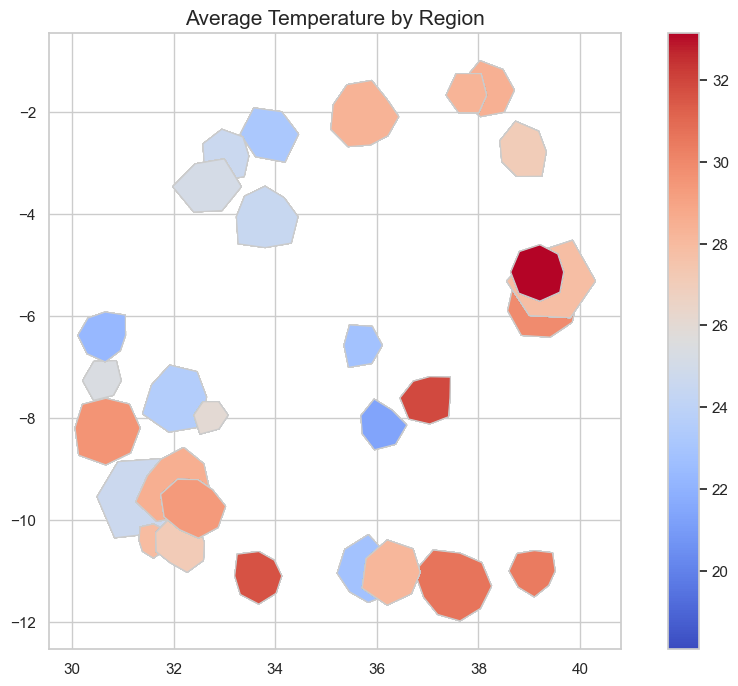

In [91]:
# TODO: Create a choropleth map of average temperature by region
# Step 1: Select representative regions (example regions)
# Hint: Use the .plot() method with the column parameter
def create_choropleth(gdf, column, title, cmap='viridis', figsize=(12, 8)):
    """Create a choropleth map for a GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to plot
    column (str): The column to use for coloring
    title (str): The title of the map
    cmap (str or Colormap): The colormap to use
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    # TODO: Implement this function
    # Plotting the choropleth map
    # Plotting the choropleth map
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plotting the GeoDataFrame with the specified column and colormap
    gdf.plot(column=column, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    
    # Adding the title
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '3'})
    
    # Display the plot
    plt.show()

# Create the choropleth map for average temperature
temp_map = create_choropleth(tz_climate, 'ANNUAL_AVG_TEMP_C', 'Average Temperature by Region', cmap='coolwarm')

### Task 3.2: Create a Time Series Visualization
Create a time series visualization showing temperature trends over time for selected regions.

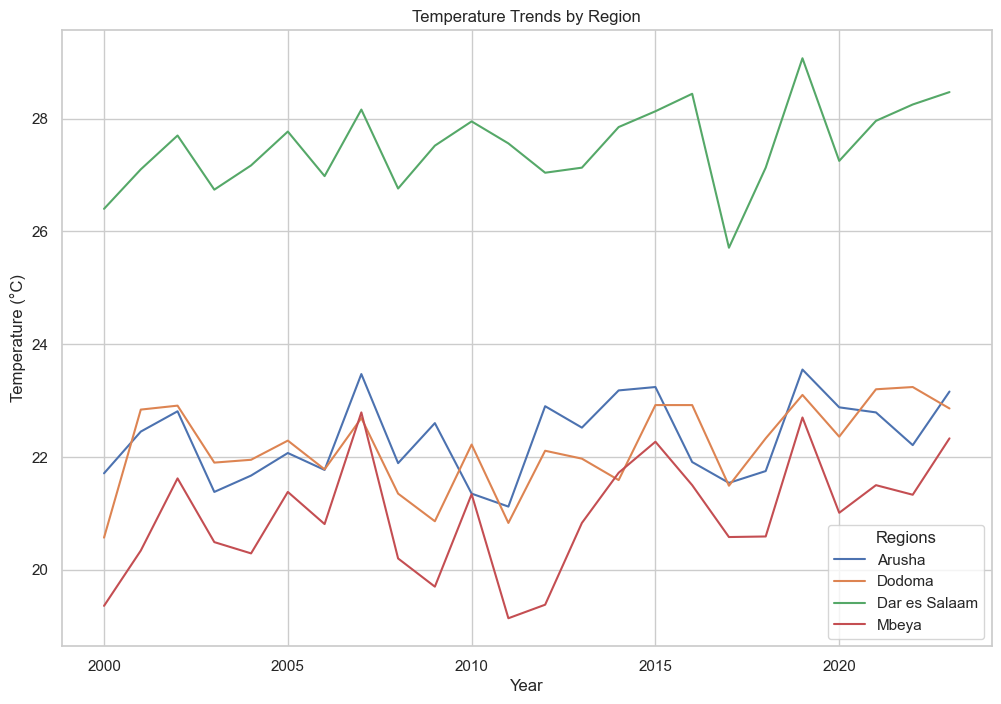

In [79]:
# TODO: Select a few representative regions for the time series
# Step 1: Select representative regions (example regions)
# Step 1: Select representative regions (example regions

# Step 1: Select representative regions (example regions)
selected_regions = ['Arusha', 'Dodoma', 'Dar es Salaam', 'Mbeya']  # Adjust based on available regions in your data

# Step 2: Filter the climate data for these regions
region_climate_data = climate_data[climate_data['REGION_NAME'].isin(selected_regions)]

# Step 3: Create the time series plot function
def plot_time_series(df, regions, time_column, value_column, title, figsize=(12, 8)):
    """Create a time series plot for selected regions.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data
    regions (list): The list of regions to include
    time_column (str): The column containing time information
    value_column (str): The column containing the values to plot
    title (str): The title of the plot
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    # Step 2: Filter data for the selected regions
    selected_data = df[df['REGION_NAME'].isin(regions)]
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Loop through selected regions and plot the time series
    for region in regions:
        region_data = selected_data[selected_data['REGION_NAME'] == region]
        plt.plot(region_data[time_column], region_data[value_column], label=region)
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.legend(title='Regions')
    
    # Display the plot
    plt.show()

# Step 4: Plot the time series for average temperature
temp_time_series = plot_time_series(region_climate_data, selected_regions, 'YEAR', 'ANNUAL_AVG_TEMP_C', 'Temperature Trends by Region')


### Task 3.3: Create an Interactive Map
Create an interactive map showing climate data using Folium.

In [92]:
# TODO: Convert the projected GeoDataFrame to WGS84 for use with Folium
tz_wgs84 = tz_climate.to_crs(epsg=4326)  # Convert to WGS84 (EPSG:4326)

# TODO: Create an interactive map using Folium
def create_interactive_map(gdf, column, popup_columns, title, center=None, zoom_start=6):
    """Create an interactive map using Folium.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to map (must be in WGS84)
    column (str): The column to use for coloring
    popup_columns (list): Columns to include in the popup
    title (str): The title of the map
    center (tuple): The center coordinates [lat, lon]
    zoom_start (int): The initial zoom level
    
    Returns:
    folium.Map: The created interactive map
    """
    import folium
    
    # Create the base map
    m = folium.Map(location=center if center else [6.792, 39.208], zoom_start=zoom_start, control_scale=True)
    
    # Add a choropleth layer to the map
    choropleth = folium.Choropleth(
        geo_data=gdf,
        data=gdf,
        columns=['REGION_NAM', column],  # Use the correct column name 'REGION_NAM'
        key_on='feature.properties.REGION_NAM',  # Update this key to match 'REGION_NAM'
        fill_color='YlGn',  # Color scheme
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=title
    ).add_to(m)

    # Add popups for each region
    for idx, row in gdf.iterrows():
        popup_info = {col: row[col] for col in popup_columns}
        popup = folium.Popup(popup_info, max_width=300)
        folium.Marker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x], 
            popup=popup
        ).add_to(m)

    return m

# usage of the function
interactive_map = create_interactive_map(
    tz_wgs84, 
    'ANNUAL_AVG_TEMP_C',  # Replace with the actual column you want to use for coloring
    ['REGION_NAM', 'ANNUAL_AVG_TEMP_C'],  # Columns to display in the popup
    'Average Temperature by Region',
    center=[-6.792, 39.208],  # Centered around Dar es Salaam, Tanzania
    zoom_start=6
)

# To display the map in a Jupyter notebook
interactive_map

## Part 4: Climate Change EDA

### Task 4.1: Analyze Temperature Trends
Analyze the trends in temperature across Tanzania over time.

In [ ]:
# TODO: Calculate temperature trends for each region
from scipy.stats import linregress

def calculate_temperature_trends(df, region_column, year_column, temp_column):
    """Calculate temperature trends for each region.
    
    Parameters:
    df (DataFrame): The DataFrame containing climate data
    region_column (str): The column containing region identifiers
    year_column (str): The column containing year information
    temp_column (str): The column containing temperature values
    
    Returns:
    DataFrame: A DataFrame containing trend information for each region
    """
    trends = []
    
    for region in df[region_column].unique():
        region_data = df[df[region_column] == region].sort_values(by=year_column)

        if len(region_data) < 2:  # Need at least two data points for trend calculation
            continue
        
        slope, intercept, r_value, p_value, std_err = linregress(region_data[year_column], region_data[temp_column])
        
        trends.append({
            region_column: region,
            'Trend': slope,  # Temperature change per year
            'R-squared': r_value ** 2  # Goodness of fit
        })
    
    return pd.DataFrame(trends)


### Task 4.2: Identify Climate Change Hotspots
Identify regions in Tanzania that are experiencing the most significant climate change.

C:\Users\Hp\AppData\Local\Temp\ipykernel_1276\546170655.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_column, y=region_column, data=trends_df.sort_values(trend_column, ascending=False), palette='coolwarm')


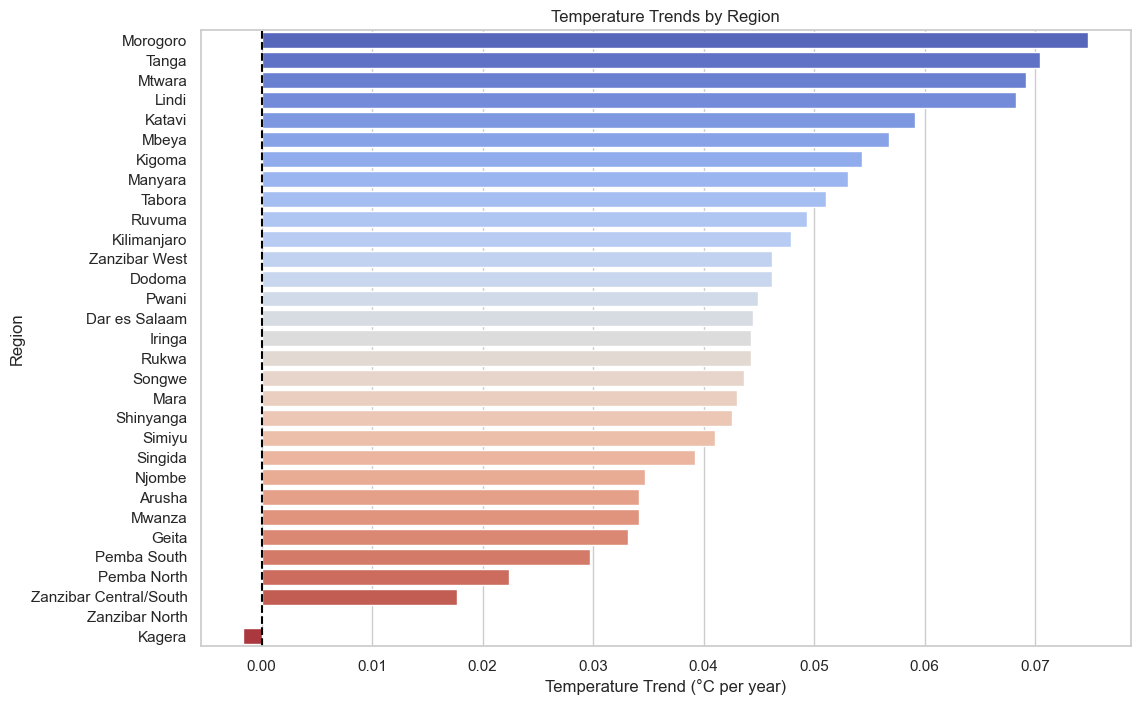

In [96]:
from sklearn.linear_model import LinearRegression

def calculate_temperature_trends(df, region_column, year_column, temp_column):
    """Calculate temperature trends for each region using linear regression."""
    trends = []
    
    for region, group in df.groupby(region_column):
        group = group.sort_values(year_column)  # Ensure data is sorted by year
        X = group[year_column].values.reshape(-1, 1)  # Reshape for regression
        y = group[temp_column].values
        
        if len(X) > 1:  # Perform regression only if there are multiple years
            model = LinearRegression()
            model.fit(X, y)
            trend = model.coef_[0]  # Get slope of the trend line
        else:
            trend = np.nan  # Assign NaN if there's not enough data
        
        trends.append({region_column: region, "Trend": trend})
    
    return pd.DataFrame(trends)

def plot_temperature_trends(trends_df, region_column, trend_column, title, figsize=(12, 8)):
    """Plot temperature trends by region using a bar chart."""
    plt.figure(figsize=figsize)
    sns.barplot(x=trend_column, y=region_column, data=trends_df.sort_values(trend_column, ascending=False), palette='coolwarm')
    plt.axvline(0, color='black', linestyle='--')  # Reference line for zero trend
    plt.xlabel("Temperature Trend (°C per year)")
    plt.ylabel("Region")
    plt.title(title)
    plt.show()

def identify_hotspots(climate_df, criteria_columns, threshold_values):
    """Identify climate change hotspots based on specified criteria."""
    hotspot_mask = np.ones(len(climate_df), dtype=bool)
    
    for col, threshold in threshold_values.items():
        hotspot_mask &= climate_df[col] >= threshold
    
    return climate_df[hotspot_mask]

# Example usage (replace 'climate_data' with your actual DataFrame)
temp_trends = calculate_temperature_trends(climate_data, 'REGION_NAME', 'YEAR', 'ANNUAL_AVG_TEMP_C')
plot_temperature_trends(temp_trends, 'REGION_NAME', 'Trend', "Temperature Trends by Region")

# Define thresholds for hotspots
thresholds = {"Trend": 0.02, "ANNUAL_HEAVY_RAIN_DAYS": 30, "ANNUAL_DROUGHT_INDEX": 5}
hotspots = identify_hotspots(climate_data, ["Trend", "ANNUAL_HEAVY_RAIN_DAYS", "ANNUAL_DROUGHT_INDEX"], thresholds)

In [70]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Calculate temperature trends (slopes) for each region
def calculate_temperature_trends(df, region_column, year_column, temp_column):
    """Calculate temperature trends (slopes) for each region based on temperature data over the years."""
    trends = []

    # Loop through each region
    for region in df[region_column].unique():
        # Filter data for the region
        region_data = df[df[region_column] == region]
        
        # Sort the data by year to ensure correct chronological order
        region_data = region_data.sort_values(by=year_column)
        
        # Prepare the data for linear regression
        X = region_data[year_column].values.reshape(-1, 1)  # Reshape years to be the input feature
        y = region_data[temp_column].values  # Temperature values as the target
        
        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X, y)
        
        # Get the slope (trend) for the region
        trend = model.coef_[0]  # The slope of the line (temperature change per year)
        
        # Store the trend with the region name
        trends.append({'Region': region, 'Trend': trend})
    
    # Convert the list of trends to a DataFrame
    trends_df = pd.DataFrame(trends)
    
    # Merge the trends back into the original dataframe
    df_with_trends = pd.merge(df, trends_df, how='left', left_on=region_column, right_on='Region')
    df_with_trends.drop(columns=['Region'], inplace=True)  # Drop the 'Region' column from trends
    
    return df_with_trends

# Assuming climate_data is the DataFrame you're working with
climate_data_with_trends = calculate_temperature_trends(climate_data, 
                                                       region_column='REGION_NAME', 
                                                       year_column='YEAR', 
                                                       temp_column='ANNUAL_AVG_TEMP_C')

# Check the updated DataFrame to see if the 'Trend' column is now present
print(climate_data_with_trends.head())

  REGION_CODE REGION_NAME  YEAR      ZONE  ANNUAL_AVG_TEMP_C  MAX_TEMP_C  \
0          AR      Arusha  2000  Northern              21.71       26.60   
1          AR      Arusha  2001  Northern              22.45       27.81   
2          AR      Arusha  2002  Northern              22.81       27.30   
3          AR      Arusha  2003  Northern              21.38       25.77   
4          AR      Arusha  2004  Northern              21.67       26.89   

   MIN_TEMP_C  ANNUAL_PRECIP_MM  ANNUAL_RAIN_DAYS  ANNUAL_HEAVY_RAIN_DAYS  \
0       16.99            6918.2               107                      21   
1       17.78            6333.0               104                      15   
2       17.74           10795.2               144                      41   
3       16.39            5592.0                62                      10   
4       16.57           10407.2               150                      39   

   ANNUAL_DROUGHT_INDEX  ELEVATION_M  DISTANCE_TO_COAST_KM     Trend  
0        

### Task 4.3: Regional Climate Variation Analysis
Analyze how climate variables vary across different regions of Tanzania.

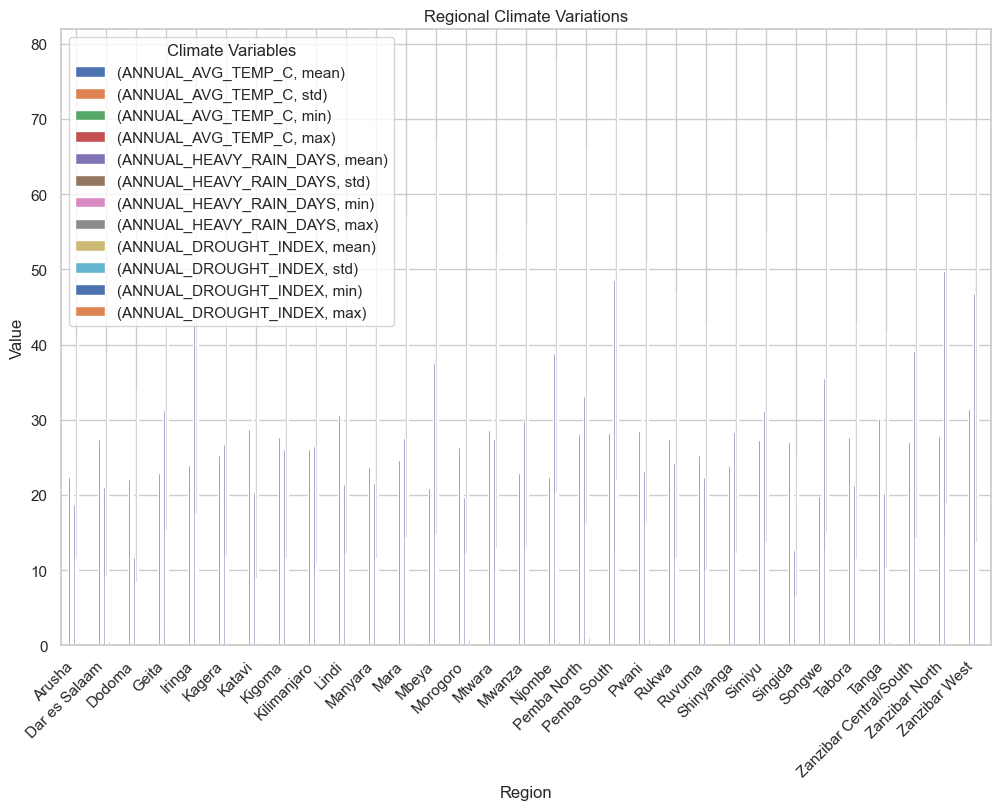

In [ ]:
# TODO: Calculate regional statistics for climate variables
def calculate_regional_stats(gdf, region_column, climate_columns):
    """Calculate statistics for climate variables by region."""
    return gdf.groupby(region_column)[climate_columns].agg(['mean', 'std', 'min', 'max']).reset_index()

def plot_regional_variations(stats_df, region_column, climate_columns, title, figsize=(12, 8)):
    """Create visualizations comparing regional climate variations."""
    fig, ax = plt.subplots(figsize=figsize)
    stats_df.set_index(region_column)[climate_columns].plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Region")
    ax.set_ylabel("Value")
    ax.legend(title="Climate Variables")
    plt.xticks(rotation=45, ha='right')
    
    return fig  # Returning the figure object

# Example usage (replace 'climate_data' with your actual DataFrame)
regional_stats = calculate_regional_stats(climate_data, 'REGION_NAME', ["ANNUAL_AVG_TEMP_C", "ANNUAL_HEAVY_RAIN_DAYS", "ANNUAL_DROUGHT_INDEX"])
variations_plot = plot_regional_variations(regional_stats, 'REGION_NAME', ["ANNUAL_AVG_TEMP_C", "ANNUAL_HEAVY_RAIN_DAYS", "ANNUAL_DROUGHT_INDEX"], "Regional Climate Variations")

## Conclusion

### Task 5: Summarize Findings
Summarize your key findings from the climate change analysis.

**TODO: Write a summary of your findings here.**

In this i found that coastal regions like Dare es salaam has more temperature compared to other cities

Your summary should include:
1. Key observations about temperature trends
2. Identified climate change hotspots
3. Notable regional variations
4. Potential implications for Tanzania
5. Recommendations for further analysis